In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime


In [2]:

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4  # Healthy, Tea leaf blight, Tea red leaf spot, Tea red scab
EPOCHS = 30
DATA_DIR = "D:/Browns/Tea Leaves Project/Tea leaf dataset"

# Enhanced Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    channel_shift_range=10.0,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)


Found 3169 images belonging to 4 classes.
Found 791 images belonging to 4 classes.
Class names: ['Healthy', 'Tea leaf blight', 'Tea red leaf spot', 'Tea red scab']


In [ ]:

# Model builder function for Keras Tuner
def build_model(hp):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(hp.Int('units', 128, 512, step=128), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Keras Tuner for hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='tea_leaf_disease'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for best hyperparameters
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]
)

best_hps = tuner.get_best_hyperparameters(1)[0]

print(f"""
Best Hyperparameters:
- Units: {best_hps.get('units')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Reloading Tuner from hyperparam_tuning\tea_leaf_disease\tuner0.json

Best Hyperparameters:
- Units: 512
- Dropout: 0.4
- Learning Rate: 0.001



In [4]:

# Final model build
model = tuner.hypermodel.build(best_hps)

# Fine-tune top layers of base model
base_model = model.layers[1]
base_model.trainable = True
for layer in base_model.layers[:-40]:  # Freeze all except last 40 layers
    layer.trainable = False

# Compile again after unfreezing
model.compile(
    optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


d:\Browns\Tea Leaves Project\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8920 - loss: 0.5061

100/100 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8924 - loss: 0.5043 - val_accuracy: 0.9798 - val_loss: 0.0865 - learning_rate: 0.0010
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9727 - loss: 0.1264

100/100 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.9728 - loss: 0.1261 - val_accuracy: 0.9810 - val_loss: 0.0585 - learning_rate: 0.0010
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9810 - loss: 0.0809

100/100 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.9810 - loss: 0.0810 - val_accuracy: 0.9924 - val_loss: 0.2280 - learning_rate: 0.0010
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9887 - loss: 0.0330

100/100 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.9887 - loss: 0.0330 - val_accuracy: 0.9937 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.9809 - loss: 0.0761 - val_accuracy: 0.9671 - val_loss: 1.1923 - learning_rate: 0.0010
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.9805 - loss: 0.1086 - val_accuracy: 0.9899 - val_loss: 0.1183 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9896 - loss: 0.0573 - val_accuracy: 0.9912 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9958 - loss: 0.0145

100/100 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.9958 - loss: 0.0146 - val_accuracy: 0.9975 - val_loss: 0.0100 - learning_rate: 2.0000e-04
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9956 - loss: 0.0173

100/100 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.9956 - loss: 0.0173 - val_accuracy: 0.9987 - val_loss: 0.0066 - learning_rate: 2.0000e-04
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.9911 - loss: 0.0318 - val_accuracy: 0.9975 - val_loss: 0.0049 - learning_rate: 2.0000e-04
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.9981 - loss: 0.0051 - val_accuracy: 0.9949 - val_loss: 0.0233 - learning_rate: 2.0000e-04
Epoch 12/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.9985 - loss: 0.0046 - val_accuracy: 0.9975 - val_loss: 0.0071 - learning_rate: 2.0000e-04
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.9981 - loss: 0.0086 - val_accuracy: 0.9987 - val_loss: 0.0027 - learning_rate: 2.0000e-04
Epoch 14/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.9977 - loss: 0.0066 - val_accuracy: 0.9962 - val_loss: 0.0072 - learning_rate: 2.0000e-04
Epoch 15/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy

100/100 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.9971 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 19/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9995 - loss: 0.0030 - val_accuracy: 0.9975 - val_loss: 0.0050 - learning_rate: 2.0000e-04
Epoch 20/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9965 - loss: 0.0132 - val_accuracy: 0.9987 - val_loss: 0.0018 - learning_rate: 2.0000e-04
Epoch 21/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.9963 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 8.1889e-04 - learning_rate: 2.0000e-04
Epoch 22/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9975 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0012 - learning_rate: 2.0000e-04
Epoch 23/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9995 - loss: 0.0033 - val_accuracy: 0.9987 - val_loss: 0.0301 - learning_rate: 2.0000e-04
Epoch 24/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accu

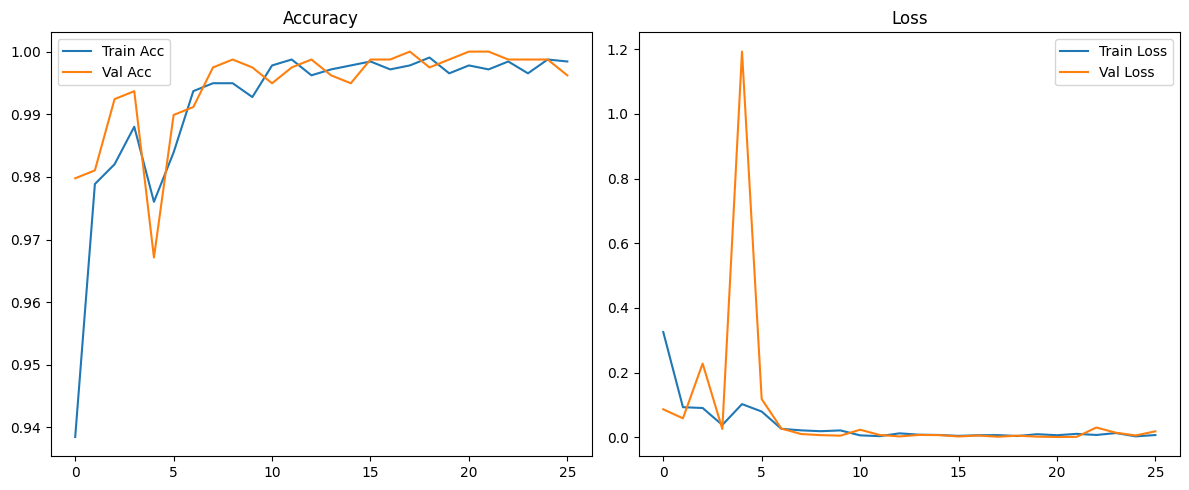

In [5]:

# Plot accuracy/loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [6]:

# Evaluation
print("Evaluating model on validation set...")
val_generator.reset()
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

# Save final model
final_model_path = f"tea_leaf_disease_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
model.save(final_model_path)
print(f"Model saved as: {final_model_path}")


Evaluating model on validation set...
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9981 - loss: 0.0032


Validation Accuracy: 99.87%
Model saved as: tea_leaf_disease_model_20250530_112303.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step

Classification Report:
                   precision    recall  f1-score   support

          Healthy       1.00      1.00      1.00       454
  Tea leaf blight       1.00      1.00      1.00       101
Tea red leaf spot       1.00      1.00      1.00       112
     Tea red scab       1.00      1.00      1.00       124

         accuracy                           1.00       791
        macro avg       1.00      1.00      1.00       791
     weighted avg       1.00      1.00      1.00       791



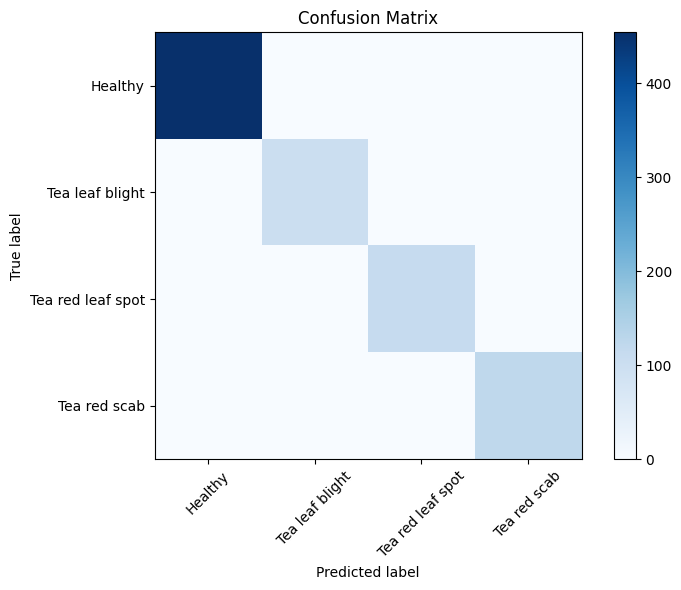

In [7]:

# Class-wise report
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


In [5]:
# Load the saved model
loaded_model = tf.keras.models.load_model(r"D:\Browns\Tea Leaves Project\tea_leaf_disease_model_20250530_112303.h5")
print("Loaded model from: successfully loaded")


Loaded model from: successfully loaded


Found 3169 images belonging to 4 classes.
Found 791 images belonging to 4 classes.
Class names: ['Healthy', 'Tea leaf blight', 'Tea red leaf spot', 'Tea red scab']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted class: Tea red leaf spot


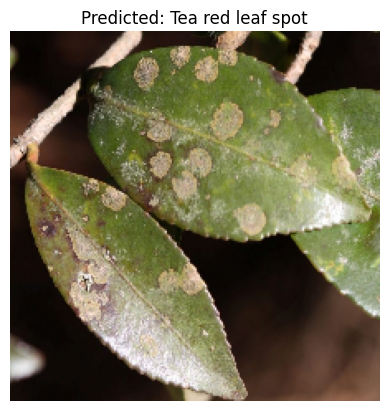

In [18]:

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4  # Healthy, Tea leaf blight, Tea red leaf spot, Tea red scab
EPOCHS = 30
DATA_DIR = "D:/Browns/Tea Leaves Project/Tea leaf dataset"

# Enhanced Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    channel_shift_range=10.0,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)


# Test the model on a sample image
# Replace 'sample.jpg' with the actual test image file name and ensure it's located appropriately
test_image_path = r"D:\Browns\Tea Leaves Project\DataForTest\algal-leaf-spot-on-camellia-leaves-e1521812206380.jpeg"
img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Make prediction
preds = loaded_model.predict(img_array)
predicted_class = class_names[np.argmax(preds)]
print("Predicted class:", predicted_class)

# Display the image with the prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()